# Intro

In [182]:
import scjpnlib.utils as scjpnutils
import os
import pandas as pd
import numpy as np
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
import itertools

import json
from json_minify import json_minify
import pprint

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import scjpnlib.utils.skl_transformers as scjpnskltransformers
import scjpnlib.utils.strategy_transformers as scjpnstrattransformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from scjpnlib.utils import submodels as scjpnsubmodels

# leave these in until port is complete 
from scjpnlib.utils.skl_transformers import DropColumnsTransformer, LambdaTransformer, SimpleValueTransformer, OneHotEncodingTransformer, LabelEncodingTransformer, TargetEncoderLOOTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from copy import deepcopy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
fm = FileManager()
eda_config = fm.load_json('eda-config-new.txt')

In [184]:
if len(eda_config['wrangled_data']['dir']) > 0:
    WRANGLED_DATA_DIR = eda_config['wrangled_data']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{WRANGLED_DATA_DIR}")
    except FileExistsError:
        pass
    WRANGLED_DATA_DIR += "/"
else:
    WRANGLED_DATA_DIR = ""

if len(eda_config['labels']['dir']) > 0:
    SAVE_LABELS_DIR = eda_config['labels']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{SAVE_LABELS_DIR}")
    except FileExistsError:
        pass
    SAVE_LABELS_DIR += "/"
else:
    SAVE_LABELS_DIR = ""

    
fname__train_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(eda_config, data_kwargs={'is_labels':False,'type':'train'})
print(f"wrangled/preprocessed training predictors will be saved to: {fname__train_predictors}")
fname__train_labels = SAVE_LABELS_DIR + scjpnutils.get_data_fname(eda_config, data_kwargs={'is_labels':True,'type':'train'})
print(f"training labels will be saved to: {fname__train_labels}")

fname__validation_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(eda_config, data_kwargs={'is_labels':False,'type':'test'})
print(f"wrangled/preprocessed validation predictors will be saved to: {fname__validation_predictors}")
fname__validation_labels = SAVE_LABELS_DIR + scjpnutils.get_data_fname(eda_config, data_kwargs={'is_labels':True,'type':'test'})
print(f"validation labels will be saved to: {fname__validation_labels}")

fname__unlabeled_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(eda_config, data_kwargs={'is_labels':False,'type':'unlabeled'})
print(f"wrangled/preprocessed unlabeled predictors will be saved to: {fname__unlabeled_predictors}")

wrangled/preprocessed training predictors will be saved to: preprocessing-results/wrangled-labeled-data-train-e8d7a8a060a2e2a35e63f5df535a2f2e.csv
training labels will be saved to: preprocessing-results/labels-train-e8d7a8a060a2e2a35e63f5df535a2f2e.csv
wrangled/preprocessed validation predictors will be saved to: preprocessing-results/wrangled-labeled-data-test-e8d7a8a060a2e2a35e63f5df535a2f2e.csv
validation labels will be saved to: preprocessing-results/labels-test-e8d7a8a060a2e2a35e63f5df535a2f2e.csv
wrangled/preprocessed unlabeled predictors will be saved to: preprocessing-results/wrangled-unlabeled-data-e8d7a8a060a2e2a35e63f5df535a2f2e.csv


In [185]:
display(HTML(f"<b>NOTE: <i>for the above EDA configuration, wrangled/preprocessed and partitioned label output files will be identified (filename suffix) by: hash digest: {scjpnutils.json_to_md5_hash_digest(eda_config)}</i></b>"))

In [186]:
fname_unlabeled_predictors = eda_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = eda_config['official_data']['labeled_predictors']['local_fname']
fname_labels = eda_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: eda_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: eda_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: eda_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [187]:
SEED = eda_config['SEED'] # for random_state reproducability

pipeline_data_preprocessor = Pipeline(steps=[('passthrough', None)], verbose=True)

In [188]:
# scjpnutils.display_pretty_feature_groupings(eda_config['feature_groupings'], include_preprocessing=True)

In [189]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

In [190]:
labels = labeled_with_target[['status_group']]

In [191]:
let_labels = scjpnskltransformers.LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)

In [192]:
classes = list(let_labels.labelencoder.classes_)

In [193]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

In [194]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)
X_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0).sort_index()

In [195]:
X_train, X_validation, y_train, y_validation = train_test_split(X_labeled.sort_index(), labels.sort_index(), test_size=eda_config['test_ratio'], random_state=SEED)

In [196]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [197]:
data_train = pd.concat([X_train, y_train, y_train_encoded], axis=1, join='inner').sort_index()
data_train.columns = list(X_train.columns) + ['status_group', 'status_group_encoded']

In [198]:
y_validation_encoded = labels_encoded.loc[y_validation.index]

In [199]:
data_validation = pd.concat([X_validation, y_validation, y_validation_encoded], axis=1, join='inner').sort_index()
data_validation.columns = list(X_validation.columns) + ['status_group', 'status_group_encoded']

## Execute Minimal Set of Transformations Required to Build Models

Before we get into a systematic search for which preprocessing options we have available (that we found in EDA) are "best", let's execute the so-called minimal "required" transformations (again, that we found in EDA).

In [200]:
def exec_preprocessing_option(preprocessing_group_name, option_strategy_composition, X, y, pipeline):
    strat_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
        option_strategy_composition, 
        preprocessing_group_name,
        pipeline
    )
    scjpnstrattransformers.html_prettify_strategy_transformer_description(strat_transformer)
    return strat_transformer.fit_transform(X, y), strat_transformer

In [201]:
# X_train_augmented_baseline = X_train.copy()

# transformed_feat_names = []
# for idx, preprocessing_option in enumerate(eda_config['feature_groupings']['minimal_required__group']['preprocessing_options']['all_required']):
#     X_train_augmented_baseline, composite_transformer = exec_preprocessing_option(
#         'all_required', 
#         preprocessing_option, 
#         X_train_augmented_baseline, 
#         y_train_encoded.status_group, 
#         pipeline_data_preprocessor
#     )
#     scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_feat_names)
# transformed_feat_names = list(set(transformed_feat_names))

<p><br>

## Summary of Preprocessing Options and Brute-force (Bad) Complexity

In [202]:
cartesian_prod = 1
brute_force_complexity = []
for feat_group_name in eda_config['feature_groupings']:
    preprocessing_options = eda_config['feature_groupings'][feat_group_name]['preprocessing_options']

    features = eda_config['feature_groupings'][feat_group_name]['features']

    display(HTML(f"<b>{feat_group_name}</b> feature-group has {len(features)} features ({features}) handled across {len(preprocessing_options)} preprocessing groups:"))

    # print(eda_config['feature_groupings'][feat_group_name]['preprocessing_options'])
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        brute_force_complexity.append((preprocessing_group_name, opts_for_group))

        display(HTML(f"{scjpnutils.helper__HTML_tabs(1)}preprocessing group <b>{preprocessing_group_name}</b> has {len(opts_for_group)} preprocessing options"))
        cartesian_prod *= len(opts_for_group)

        for idx, preprocessing_option in enumerate(opts_for_group):
            display(HTML(f"{scjpnutils.helper__HTML_tabs(2)}option {idx+1}: {preprocessing_option}"))

        display(HTML("<p>"))

    display(HTML("<p><br>"))

s_brute_force_complexity = '\\times '.join(['|'+t_ppg_ofg[0]+'|' for t_ppg_ofg in brute_force_complexity])
s_brute_force_complexity = f"$O({s_brute_force_complexity})$"
display(Markdown(f"brute-force complexity: {s_brute_force_complexity}"))

# s_list_of_preprocessing_groups = pprint.pformat(list_of_preprocessing_groups, indent=4)
# print(f"\nlist of feat-preprocessing-options:\n{s_list_of_preprocessing_groups}")

display(Markdown(f"$= {cartesian_prod}$ (brute-force iterations!)"))
# cartesian_prod = list(itertools.product(*list_of_preprocessing_groups)) # DO NOT UNCOMMENT THIS!  THIS TAKES A VERY LONG TIME TO COMPUTE.  IT IS ONLY HERE FOR REFERENCE.
# print(f"\n\nsize of cartesian-product (itertools): {len(cartesian_prod)}")

brute-force complexity: $O(|amount_tsh|\times |pump_age|\times |funder|\times |gps_height|\times |installer|\times |gps_coordinates|\times |wpt_name|\times |num_private|\times |basin|\times |region_code|\times |district_code|\times |subvillage|\times |region|\times |lga|\times |ward|\times |population|\times |public_meeting|\times |recorded_by|\times |scheme_management|\times |scheme_name|\times |permit|\times |extraction_type|\times |extraction_type_group|\times |extraction_type_class|\times |management|\times |management_group|\times |payment_type|\times |payment|\times |water_quality|\times |quality_group|\times |water_quality|\times |quantity_group|\times |source|\times |source_type|\times |source_class|\times |waterpoint_type|\times |waterpoint_type_group|)$

$= 92897280$ (brute-force iterations!)

You read that correctly: if we do this using brute-force, that would be building (transforming) more than 46 million data sets!

That is obviously intractible.  

Consider the case when transforming both X_train and X_validation take, on average, 1 minute apiece.

There are 525600 minutes in one year.

**Doing the brute-force way would require 93 million minutes, which is about 177 years!**  LOL!

Instead, we will use a Greedy Algorithm to make this a linear problem.

## Baselining the Greedy Way

The idea goes like this:

1. Build a baseline model using the most features possible - since a lot of features contains `nan` values, this precludes the use of `DecisionTreeClassifier` and `RandomForestClassifier` for baselining; thus, we will baseline using `XGBClassifier` since it allows `nan`s.
2. From there, we will try out each option for each feature-group (specified in the config) - to be clear, we will include the baseline features plus those involved in the particular preprocessing option.
3. Build a model (with `XGBClassifier`) and compare its validation accuracy to the validation accuracy of the baseline model - if it goes down or stays the same, this obviously is not a good preprocessing option to keep; if it goes up from the baseline, then we will obviously keep this preprocessing option; we will keep the option that garners the best improvement on a per-feature-group basis.

### Build Baseline Model

We use this as a basis for comparison to demonstrate iterative permformance when examine available preprocessing options for a given feature-group.

The idea is to use a classifier that is flexible enough to deal with as many of the features from the untouched training data set.  As we have seen, there are plenty of null/missing values in the raw data set.  So we want a classifier that can readily handle nulls.  That rules out using `DecisionTreeClassifier` or `RandomForestClassifier` for our baseline model.  `XGBClassifier`, on the other hand, can handle `nan`s just fine.  So we will use it to build our baseline and inspect various preprocessing options using it.

However, for `XGBClassifier`, values it models must be an `int`, `float`, or `bool`.

Thus, we need to filter out any features that are not of that type.

In [203]:
X_train_baseline = X_train.select_dtypes(['number', 'bool'])
baseline_cols = list(X_train_baseline.columns)
baseline_cols

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [204]:
X_train_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   gps_height         53460 non-null  int64  
 2   longitude          53460 non-null  float64
 3   latitude           53460 non-null  float64
 4   num_private        53460 non-null  int64  
 5   region_code        53460 non-null  int64  
 6   district_code      53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   construction_year  53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


In [205]:
X_validation_baseline = X_validation[baseline_cols]

In [206]:
def summarize_preds(clf, X, y, preds, dataset_name, classes):
    display(HTML("<p><br>"))
    _accuracy = accuracy_score(y, preds)
    display(HTML(f"{dataset_name} Accuracy: {round(_accuracy*100,4)}"))
    display(HTML("<p><br>"))
    display(HTML(f"<pre>{classification_report(y, preds, target_names=classes)}</pre>"))
    return _accuracy

In [207]:
clf = XGBClassifier(max_depth=10, n_jobs=-1)
clf.fit(X_train_baseline, y_train_encoded.status_group)

pred_validation_baseline = clf.predict(X_validation_baseline)
_accuracy_validation_baseline = summarize_preds(clf, X_validation_baseline, y_validation_encoded.status_group, pred_validation_baseline, 'Validation', classes)

In [208]:
# X_train_minimum_req_preprocessing = X_train.copy()

# transformed_feat_names = []
# for idx, preprocessing_option in enumerate(eda_config['feature_groupings']['minimal_required__group']['preprocessing_options']['all_required']):
#     X_train_minimum_req_preprocessing, composite_transformer = exec_preprocessing_option(
#         'all_required', 
#         preprocessing_option, 
#         X_train_augmented_baseline, 
#         y_train_encoded.status_group, 
#         pipeline_data_preprocessor
#     )
#     scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_feat_names)

# X_train_minimum_req_preprocessing.info()

In [209]:
def render_HTML(s_html, not_used=None):
    display(HTML(s_html))

def find_best_option(feature_group_name, preprocessing_group_name, best_options):
    display(HTML(f"<h3>Finding best option for feature group <i>{feature_group_name}</i>, preprocessing group <i>{preprocessing_group_name}</i> after baseline...</h3>"))

    best = None
    preprocessing__group_options = eda_config['feature_groupings'][feature_group_name]['preprocessing_options'][preprocessing_group_name]

    X_train_priors_transformed = X_train.copy()

    pipeline_priors = deepcopy(pipeline_data_preprocessor)

    cols_priors = []
    # apply best options already found preceding this one
    if len(best_options) > 0:
        display(HTML(f"<h4>Transforming X with prior best options...</h4>"))
        for prior_best_option in best_options:
            composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
                prior_best_option[1], 
                prior_best_option[0],
                pipeline_priors
            )
            scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
            X_train_priors_transformed = composite_transformer.fit_transform(X_train_priors_transformed, y_validation_encoded.status_group)

            # get list of cols transformed by this option
            transformed_cols = []
            scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
            transformed_cols = set(transformed_cols)
            # filter out any columns that were dropped
            filtered_transformed_feat_names = list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), transformed_cols))
            filtered_baseline_cols = list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), baseline_cols))
            baseline_plus_transformed_cols = list(set(filtered_baseline_cols + filtered_transformed_feat_names))
            cols_priors.extend(baseline_plus_transformed_cols)

        display(HTML(f"<h5>cols_priors: {cols_priors}</h5>"))
    
    X_acc = []
    y_acc = []
    for idx, preprocessing_option in enumerate(preprocessing__group_options):
        pipeline_temp = deepcopy(pipeline_priors)
        cols_in_model = cols_priors.copy()

        X_train_transformed, composite_transformer = exec_preprocessing_option(
            preprocessing_group_name, 
            preprocessing_option, 
            X_train_priors_transformed.copy(), 
            y_train_encoded.status_group, 
            pipeline=pipeline_temp
        )
        display(HTML(f"<h4>Building model on X transformed with current option...</h4>"))
        
        # get list of cols transformed by this option
        transformed_cols = []
        scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
        transformed_cols = set(transformed_cols)
        # filter out any columns that were dropped
        filtered_transformed_feat_names = list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), transformed_cols))
        filtered_baseline_cols = list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), baseline_cols))
        baseline_plus_transformed_cols = list(set(filtered_baseline_cols + filtered_transformed_feat_names))

        cols_in_model.extend(baseline_plus_transformed_cols)
        display(HTML(f"<h5>cols_in_model: {cols_in_model}</h5>"))

        if len(cols_in_model) > 0:
            X_acc.append(idx)

            X_train_transformed = X_train_transformed[cols_in_model]
            clf = XGBClassifier(max_depth=10)
            clf.fit(X_train_transformed, y_train_encoded.status_group)

            X_validation_transformed = pipeline_temp.transform(X_validation) 
            X_validation_transformed = X_validation_transformed[cols_in_model]
            pred_validation = clf.predict(X_validation_transformed)
            _accuracy_validation = summarize_preds(clf, X_validation_transformed, y_validation_encoded.status_group, pred_validation, 'Validation', classes)
            y_acc.append(_accuracy_validation)

            if best is None or _accuracy_validation > best[2]:
                best = (preprocessing_group_name, preprocessing_option, _accuracy_validation)
                display(HTML(f"<h5>Option {idx+1}, {best} yields new BEST validation accuracy!</h5>"))

            display(HTML("<p><br><br><br><br>"))

    plt.figure()
    plt.plot(X_acc, y_acc)
    plt.axhline(y=_accuracy_validation_baseline, color="red" if best[2] < _accuracy_validation_baseline else "green")
    plt.show()

    if best[2] < _accuracy_validation_baseline:
        display(HTML(f"<h2><font color='red'>NO OPTION INCREASES ACCURACY BEYOND BASELINE ({_accuracy_validation_baseline})!</font></h2>"))

    return best

In [210]:
# best_options = []
# find_best_option('amount_tsh__group', 'amount_tsh', best_options)

strategy "leave feature as is (do nothing): amount_tsh" appended step ['leave feature as is (do nothing): amount_tsh', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fa9ceff29e0>)] to pipeline
strategy "leave feature as is (do nothing): amount_tsh" transformation of feature "amount_tsh" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fa9ceff2dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fa9dde15bd0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fa9ceff2cb0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


strategy "replace "amount_tsh" outliers with mean" appended step ['replace "amount_tsh" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fa9eb38f9d0>] to pipeline
strategy "replace "amount_tsh" outliers with mean" transformation of feature "amount_tsh" is COMPLETE!


strategy "drop feature: amount_tsh" appended step ['drop feature: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fa9ea6f4990>] to pipeline
strategy "drop feature: amount_tsh" transformation of feature "amount_tsh" is COMPLETE!


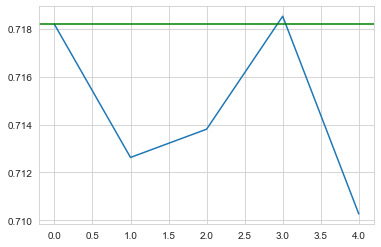

strategy "replace "amount_tsh" outliers with mean" appended step ['replace "amount_tsh" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fa9dde0c5d0>] to pipeline
strategy "replace "amount_tsh" outliers with mean" transformation of feature "amount_tsh" is COMPLETE!


NameError: free variable 'X_train_transformed' referenced before assignment in enclosing scope

In [211]:
best_options = []
for feat_group_name in eda_config['feature_groupings']:
    # if feat_group_name == 'minimal_required__group':
    #     continue

    preprocessing_options = eda_config['feature_groupings'][feat_group_name]['preprocessing_options']
    # print(f"{eda_config['feature_groupings'][feat_group_name]['preprocessing_options']}\n\n")

    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        best_option = find_best_option(feat_group_name, preprocessing_group_name, best_options)
        best_options.append((preprocessing_group_name, best_option[1]))

In [ ]:
scjpnutils.analyze_values(X_train, 'X_train BEFORE preprocessing');

In [ ]:
X_train_preprocessed = X_train.copy()

for feat_group in eda_config['feature_groupings']:
    strat_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
        eda_config['feature_groupings'][feat_group]['preprocessing_strategy'], 
        feat_group,
        pipeline_data_preprocessor
    )
    scjpnstrattransformers.html_prettify_strategy_transformer_description(strat_transformer)
    X_train_preprocessed = strat_transformer.fit_transform(X_train_preprocessed, y_train_encoded.status_group)
    display(HTML("<p><br><br>"))

In [ ]:
scjpnutils.analyze_values(X_train_preprocessed, 'X_train AFTER preprocessing');

In [ ]:
scjpnutils.analyze_values(X_validation, 'X_validation BEFORE preprocessing');

In [ ]:
X_validation_preprocessed = pipeline_data_preprocessor.transform(X_validation)

In [ ]:
scjpnutils.analyze_values(X_validation_preprocessed, 'X_validation AFTER preprocessing');